In [1]:
import os
import tempfile
import scanpy as sc

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warn

In [2]:
import seaborn as sns
import torch

In [3]:
import scvi

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.2.0


In [5]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = "/groups/tanaka/People/current/jiwang/projects/fibroticRepair_axlotl_mouse/results/scRNAseq_analysis_immune_crossSpecies_20250903/"

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [6]:
## start to import or download the data
#adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir)
adata = sc.read_h5ad(os.path.join(save_dir, 'mm_ax_scRNAseq_merged_seuratV4.h5ad'))

In [7]:
adata

AnnData object with n_obs × n_vars = 10009 × 8819
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'RNA_snn_res.0.7', 'seurat_clusters', 'RNA_snn_res.0.5', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'celltypes', 'clusters', 'subtypes', 'species', 'exp', 'type', 'RNA_snn_res.1', 'time', 'celltype', 'injury', 'batch', 'sample', 'days'
    var: 'features'

In [8]:
adata.obs[['species']]
#adata.obs[['dataset']]
#adata.layers.keys()

species
m_AAACCGCTCCCCATTG-1_1_1      mm
m_AAACGGGTCCATGCGG-1_1_1      mm
m_AAAGCTGGTGAGGATC-1_1_1      mm
m_AAATTGCTCCGTTACT-1_1_1      mm
m_AACACCATCTGTCACT-1_1_1      mm
...                          ...
ax_Cell_1603                  ax
ax_Cell_1604                  ax
ax_Cell_1605                  ax
ax_Cell_1606                  ax
ax_Cell_1607                  ax

[10009 rows x 1 columns]

In [9]:
sc.pp.filter_genes(adata, min_counts=3)

In [10]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [11]:
adata

AnnData object with n_obs × n_vars = 10009 × 8585
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'RNA_snn_res.0.7', 'seurat_clusters', 'RNA_snn_res.0.5', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'celltypes', 'clusters', 'subtypes', 'species', 'exp', 'type', 'RNA_snn_res.1', 'time', 'celltype', 'injury', 'batch', 'sample', 'days'
    var: 'features', 'n_counts'
    uns: 'log1p'
    layers: 'counts'

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
    
)

In [13]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["species"]
    #continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [29]:
#model = scvi.model.SCVI(adata)
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [30]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 3, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [32]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 400/400: 100%|██████████| 400/400 [54:45<00:00,  8.25s/it, v_num=1, train_loss_step=2.39e+3, train_loss_epoch=2.19e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [54:45<00:00,  8.21s/it, v_num=1, train_loss_step=2.39e+3, train_loss_epoch=2.19e+3]


In [ ]:
model_dir = os.path.join(save_dir, "scvi_model_ax_mm_v2")

In [33]:
model.save(model_dir, overwrite=True)

In [47]:
model_dir = os.path.join(save_dir, "scvi_model_ax_mm")

In [48]:
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File                                                                                                      
         /groups/tanaka/People/current/jiwang/projects/fibroticRepair_axlotl_mouse/results/scRNAseq_analysis_immune
         _crossSpecies_20250903/scvi_model_ax_mm/model.pt already downloaded                                       


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [49]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(10009, 40)

In [50]:
adata.obs[['subtypes']]

subtypes
m_AAACCGCTCCCCATTG-1_1_1    C1.mm
m_AAACGGGTCCATGCGG-1_1_1    C7.mm
m_AAAGCTGGTGAGGATC-1_1_1    C6.mm
m_AAATTGCTCCGTTACT-1_1_1    C7.mm
m_AACACCATCTGTCACT-1_1_1    C7.mm
...                           ...
ax_Cell_1603                C5.ax
ax_Cell_1604                C5.ax
ax_Cell_1605                C2.ax
ax_Cell_1606                C0.ax
ax_Cell_1607                C5.ax

[10009 rows x 1 columns]

In [51]:
#adata_subset = adata[adata.obs.celltype == "CM"]
#latent_subset = model.get_latent_representation(adata_subset)
#latent.shape

In [52]:
#denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
#denoised.iloc[:5, :5]

In [53]:
SCVI_NORMALIZED_KEY = "scvi_normalized"
adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

In [54]:
# Interoperability and visualization with Scanpy

In [55]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

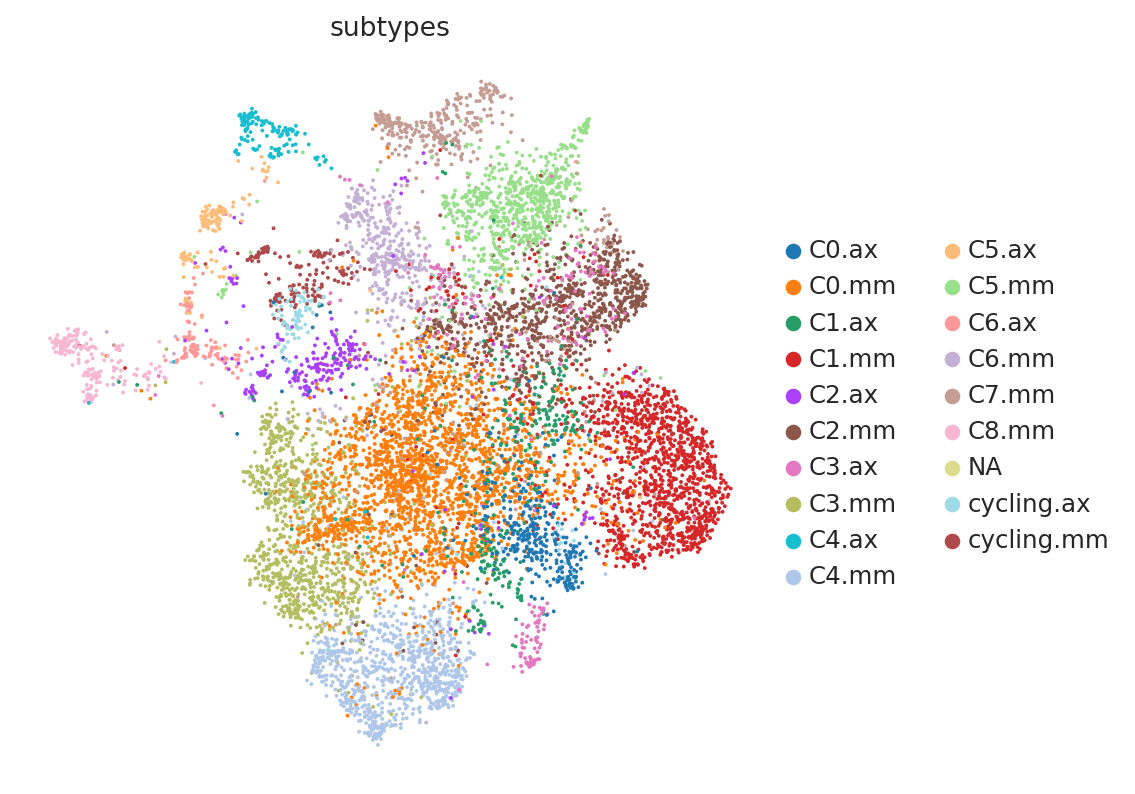

In [60]:
from matplotlib import pyplot as plt
sc.pl.umap(
    adata,
    color=["subtypes"],
    frameon=False,
    show = False
)
plt.savefig(os.path.join(save_dir, "scvi_modelv1_umap_subtypes.pdf"), bbox_inches="tight")

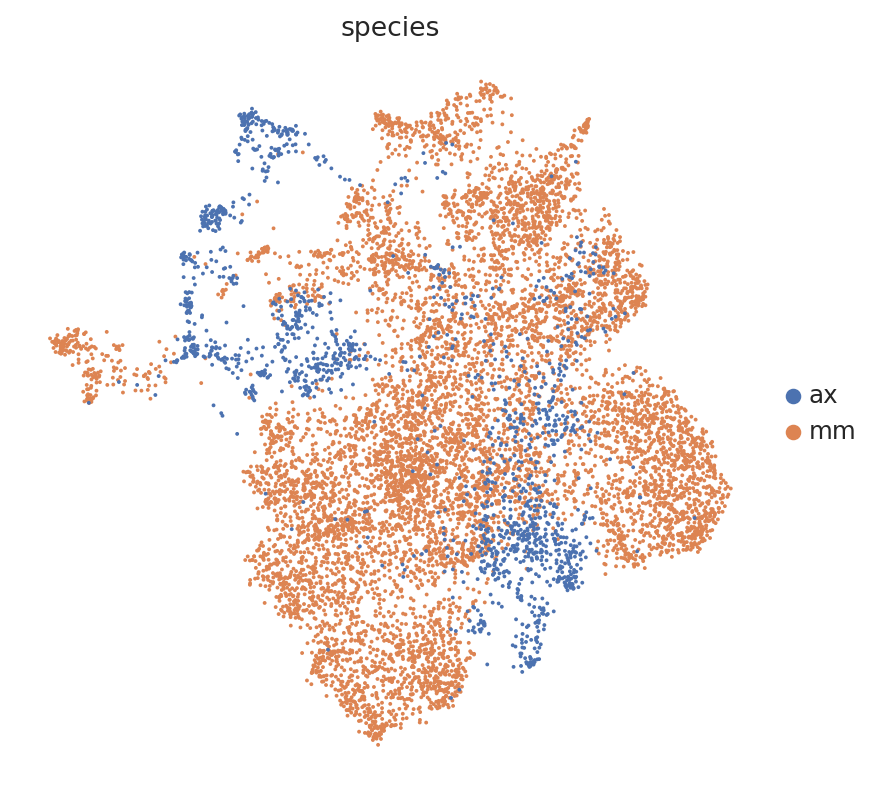

In [61]:
sc.pl.umap(
    adata,
    color=["species"],
    ncols=1,
    frameon=False,
    show = False
)
plt.savefig(os.path.join(save_dir, "scvi_modelv1_umap_species.pdf"), bbox_inches="tight")

In [27]:
# run PCA then generate UMAP plots
#sc.tl.pca(adata)
#sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
#sc.tl.umap(adata, min_dist=0.3)

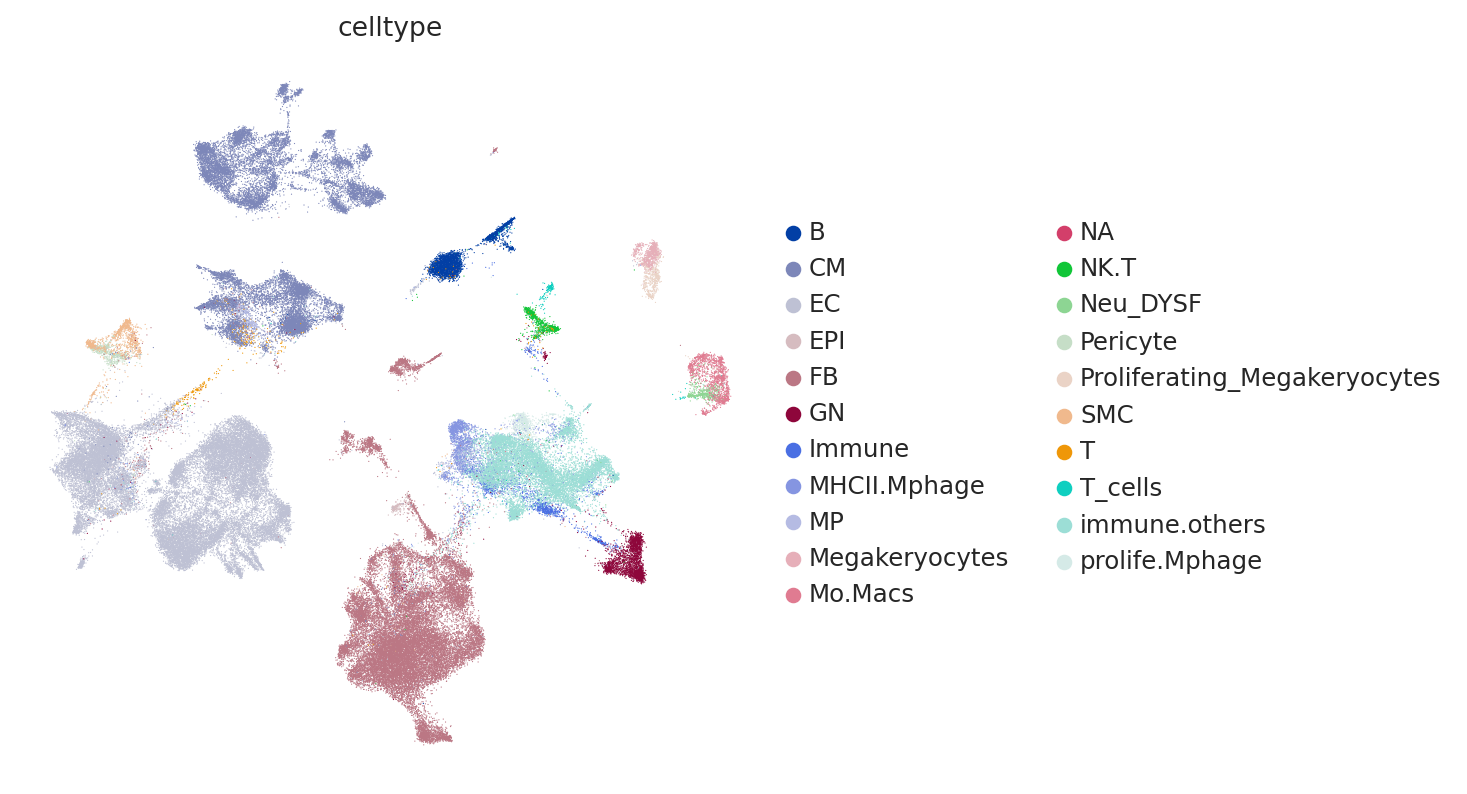

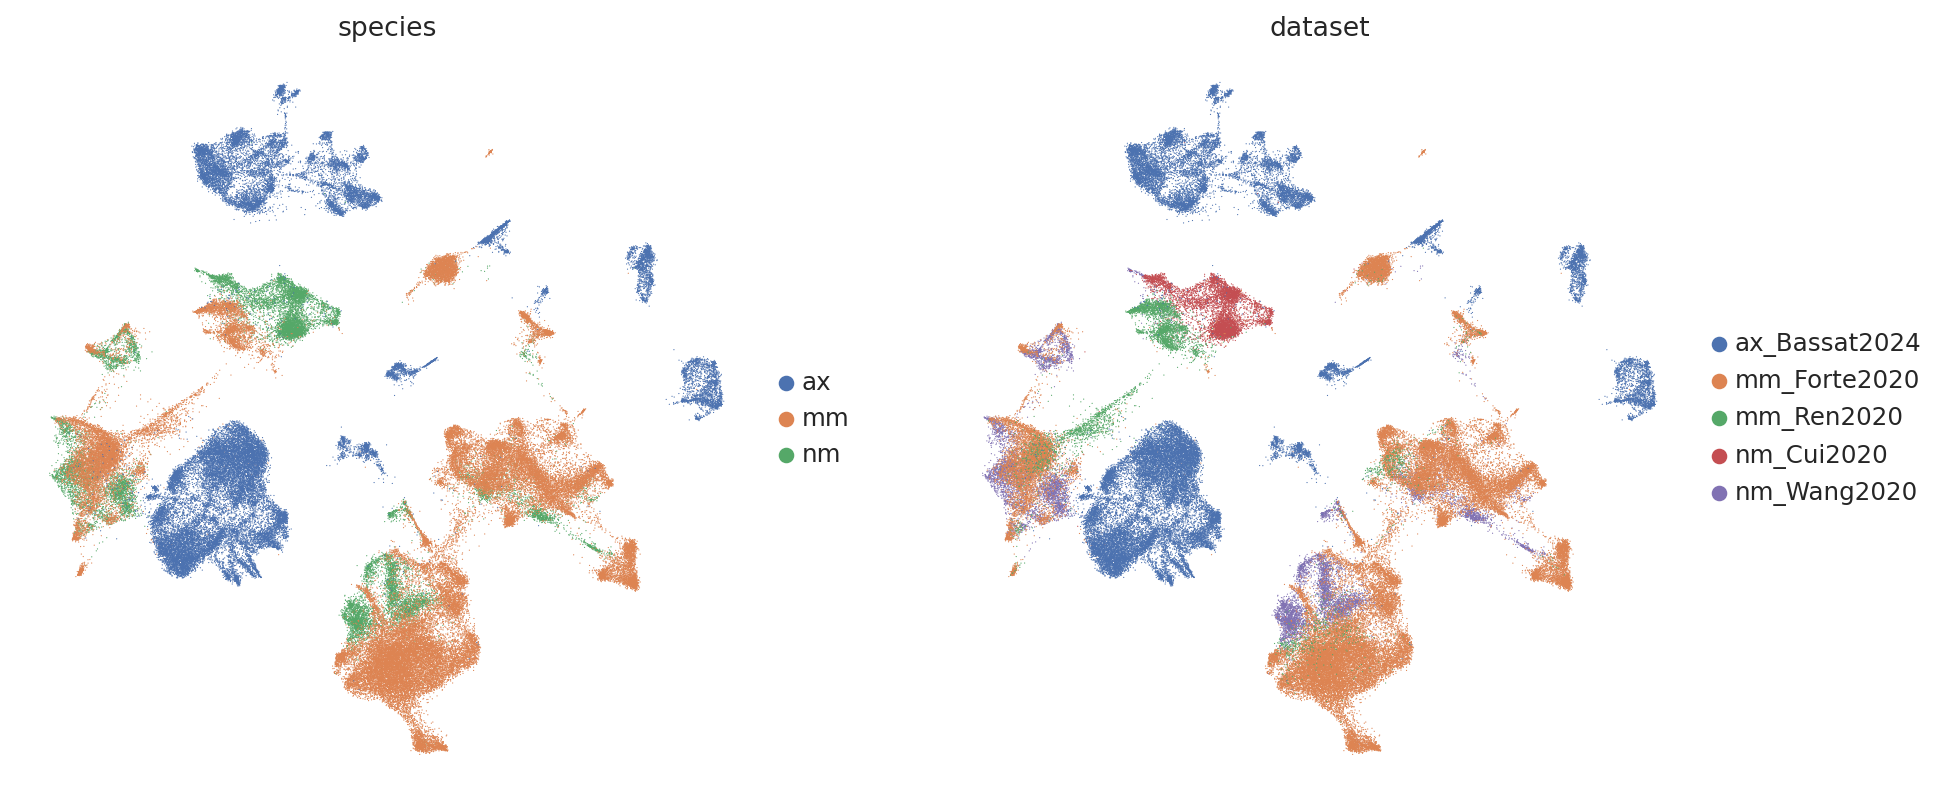

In [74]:
sc.pl.umap(
    adata,
    color=["celltype"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["species", "dataset"],
    ncols=2,
    frameon=False,
)

In [26]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

In [27]:
de_df = model.differential_expression(
    groupby="cell_type", group1="Endothelial", group2="Fibroblast"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
EGFL7     0.9996        0.0004      7.823621  0.007806  0.000289   
VWF       0.9992        0.0008      7.130086  0.013348  0.000486   
COL6A3    0.9990        0.0010      6.906745  0.000177  0.005164   
SCARA5    0.9984        0.0016      6.436144  0.000027  0.001473   
COL1A2    0.9982        0.0018      6.318161  0.000229  0.004114   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
EGFL7            0.0   0.25  5.237341    5.193677  1.714319  ...   2.376779   
VWF              0.0   0.25  5.207946    5.218299  1.830106  ...   5.072563   
COL6A3           0.0   0.25 -5.602639   -5.693408  1.781582  ...   0.026284   
SCARA5           0.0   0.25 -7.631696   -7.958348  2.953020  ...   0.003407   
COL1A2           0.0   0.25 -4.871646   -4.992768  1.674600  ...   0.021660   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
EGFL7    0.036795               0.741543               0.025756   
VWF      0.054375               0.808226               0.032298   
COL6A3   1.228131               0.021903               0.498365   
SCARA5   0.332787               0.003164               0.206868   
COL1A2   1.120196               0.016306               0.472200   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
EGFL7              89.509911              1.171088            True   
VWF               169.698700              2.210058            True   
COL6A3              1.196546             54.222549            True   
SCARA5              0.162206             14.331070            True   
COL1A2              0.914204             44.767612            True   

                       comparison       group1      group2  
EGFL7   Endothelial vs Fibroblast  Endothelial  Fibroblast  
VWF     Endothelial vs Fibroblast  Endothelial  Fibroblast  
COL6A3  Endothelial vs Fibroblast  Endothelial  Fibroblast  
SCARA5  Endothelial vs Fibroblast  Endothelial  Fibroblast  
COL1A2  Endothelial vs Fibroblast  Endothelial  Fibroblast  

[5 rows x 22 columns]

In [28]:
de_df = model.differential_expression(
    groupby="cell_type",
)
de_df.head()

DE...: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  pseudocounts  \
GPAM     0.9994        0.0006      7.417964  0.021384  0.000184           0.0   
PLIN1    0.9990        0.0010      6.906745  0.004813  0.000041           0.0   
FASN     0.9990        0.0010      6.906745  0.015508  0.000169           0.0   
DGAT2    0.9980        0.0020      6.212601  0.006353  0.000040           0.0   
CIDEC    0.9978        0.0022      6.117091  0.002249  0.000030           0.0   

       delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  raw_mean2  \
GPAM    0.25  7.346238    7.271008  2.407014  ...  17.372416   0.035791   
PLIN1   0.25  7.917045    7.759730  2.828001  ...   2.799999   0.004379   
FASN    0.25  6.617262    6.643374  2.137205  ...   7.062068   0.025086   
DGAT2   0.25  7.638672    7.762452  2.565704  ...   2.682757   0.005028   
CIDEC   0.25  7.510875    7.569562  2.868721  ...   1.137931   0.001406   

       non_zeros_proportion1  non_zeros_proportion2  raw_normalized_mean1  \
GPAM                0.896552               0.031520            280.350311   
PLIN1               0.806897               0.004325             52.928539   
FASN                0.841379               0.022167            129.082001   
DGAT2               0.593103               0.004866             43.614101   
CIDEC               0.510345               0.001406             21.810789   

       raw_normalized_mean2  is_de_fdr_0.05          comparison      group1  \
GPAM               1.566058            True  Adipocytes vs Rest  Adipocytes   
PLIN1              0.196444            True  Adipocytes vs Rest  Adipocytes   
FASN               1.084522            True  Adipocytes vs Rest  Adipocytes   
DGAT2              0.194121            True  Adipocytes vs Rest  Adipocytes   
CIDEC              0.057569            True  Adipocytes vs Rest  Adipocytes   

      group2  
GPAM    Rest  
PLIN1   Rest  
FASN    Rest  
DGAT2   Rest  
CIDEC   Rest  

[5 rows x 22 columns]

In [29]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [30]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

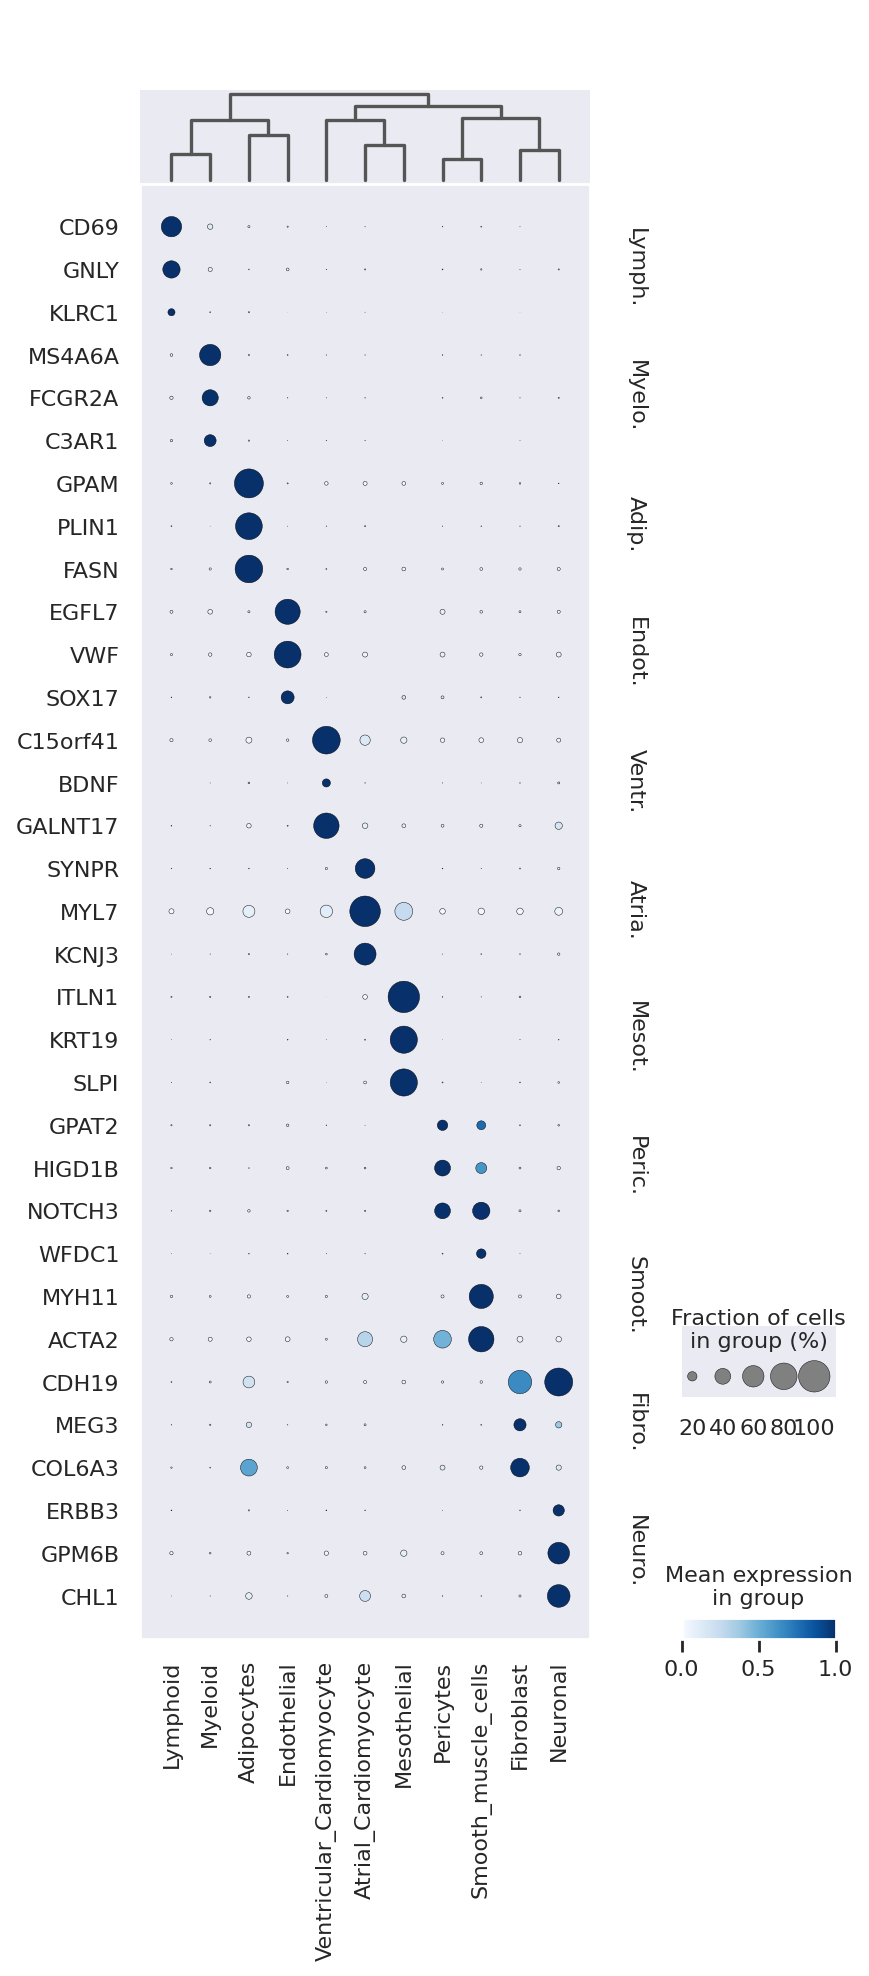

In [31]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="cell_type",
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

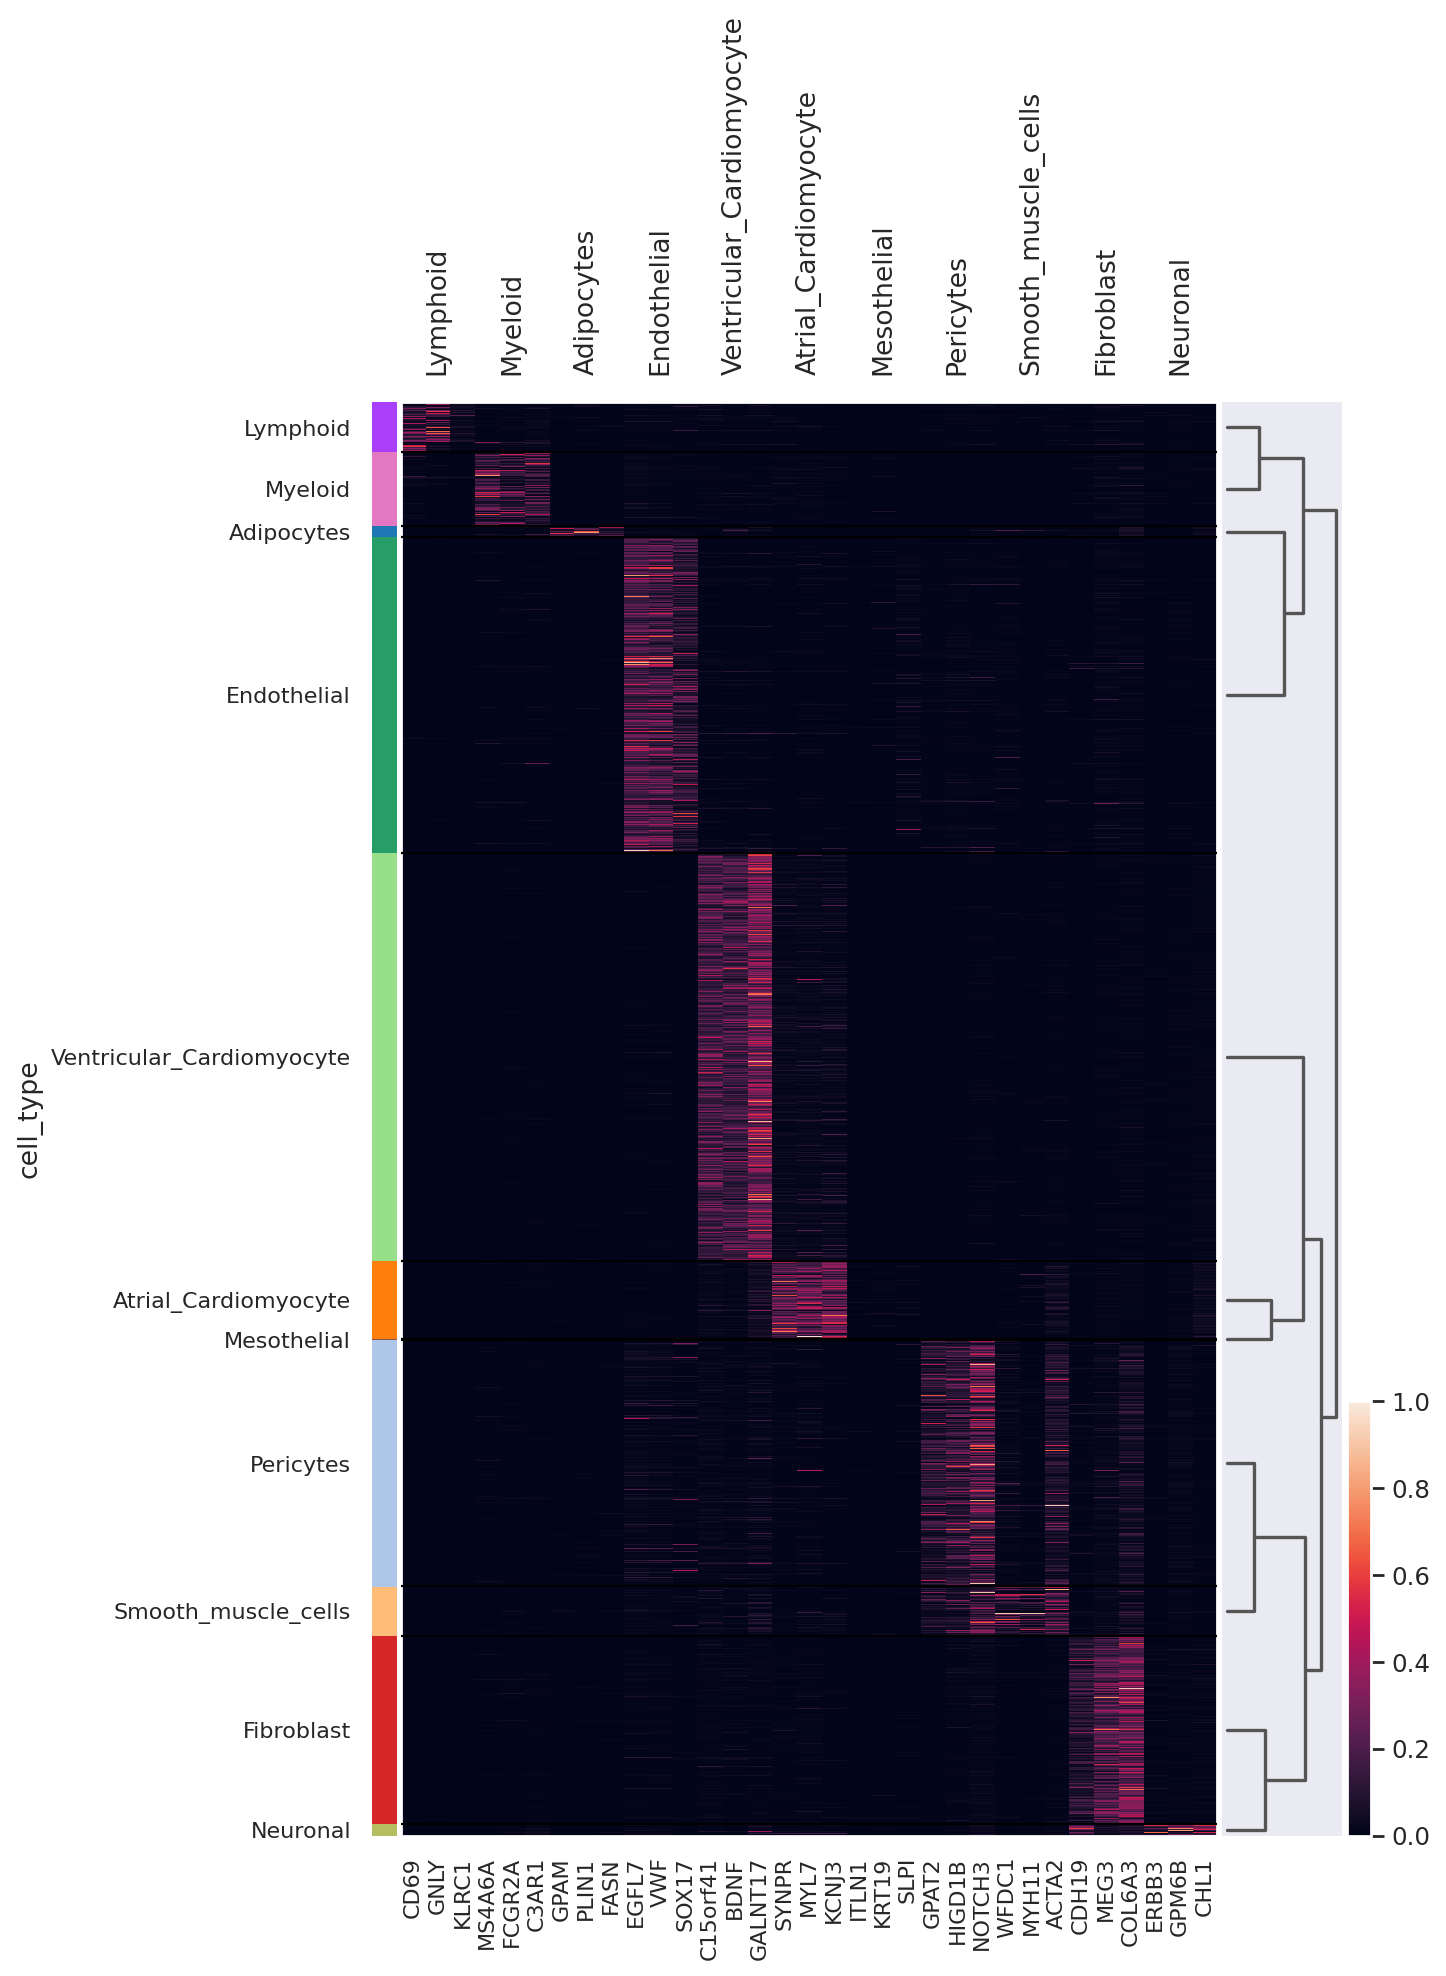

In [32]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="cell_type",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)

In [ ]:
## test scANVI 
## original code from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html

In [6]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

In [7]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
#save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [8]:
adata_path = os.path.join(save_dir, "lung_atlas.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [9]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [10]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [11]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [12]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 246/246: 100%|██████████| 246/246 [22:34<00:00,  5.22s/it, v_num=1, train_loss_step=550, train_loss_epoch=552]

`Trainer.fit` stopped: `max_epochs=246` reached.


Epoch 246/246: 100%|██████████| 246/246 [22:34<00:00,  5.51s/it, v_num=1, train_loss_step=550, train_loss_epoch=552]


In [16]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [17]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

In [18]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY], accelerator="cpu")

INFO     Using cpu for `pymde.preserve_neighbors`.                                                                 


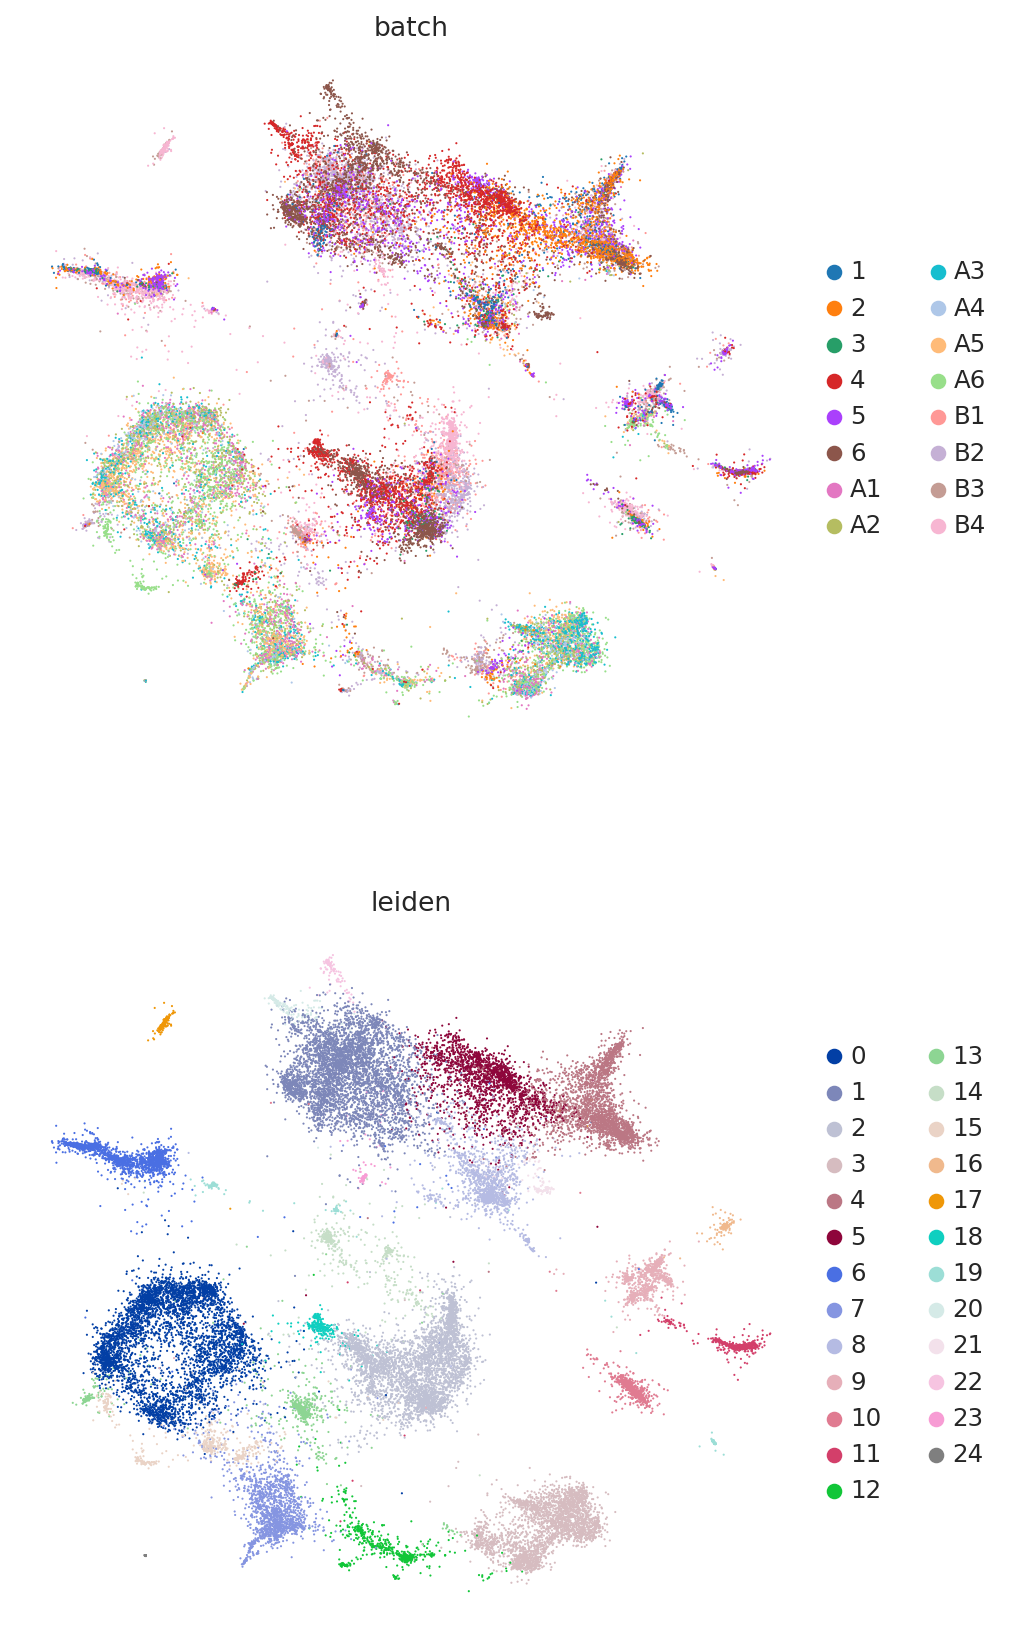

In [19]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

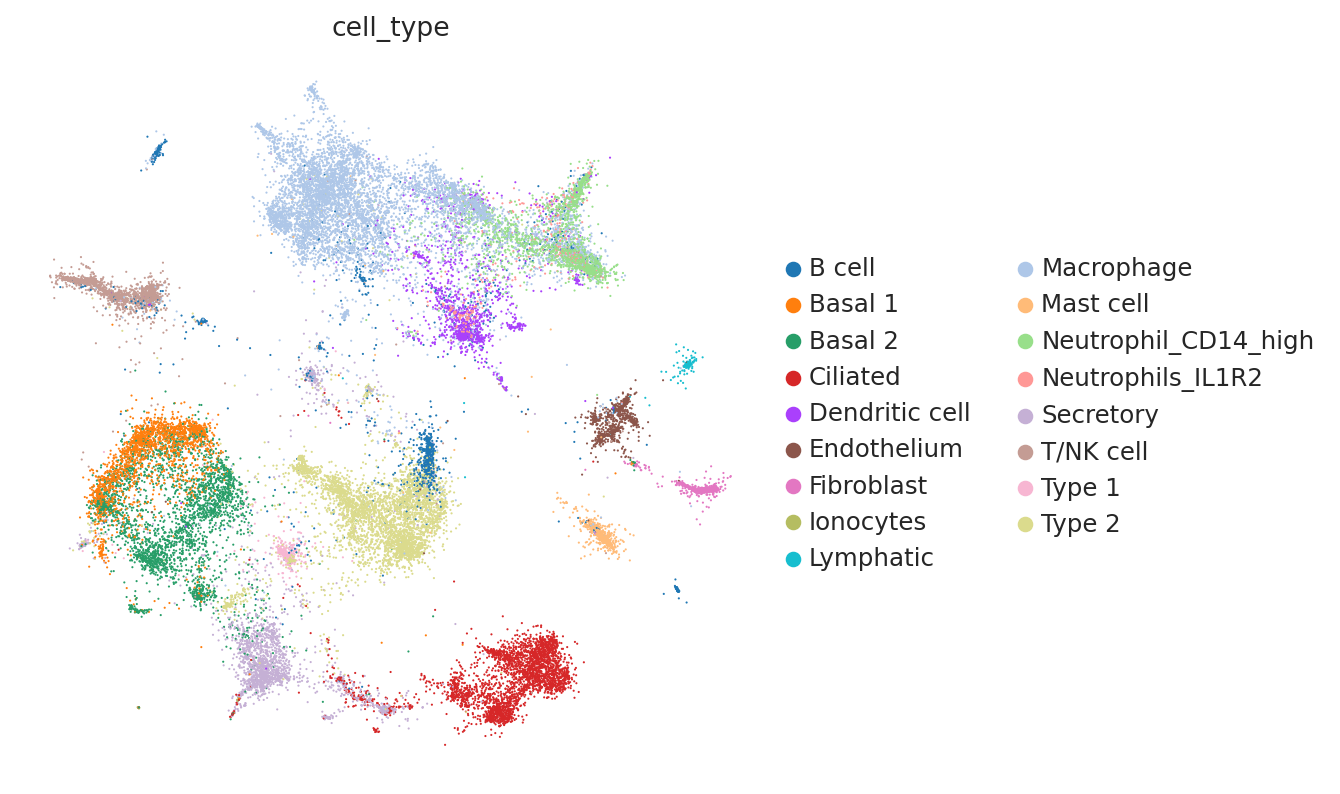

In [20]:
sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color=["cell_type"], frameon=False, ncols=1)

In [21]:
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'batch_colors', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_scVI', 'X_scVI_MDE'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [22]:
adata.obs['cell_type']

index
GAGGGGCCAGCC                                                            Type 2
ACATAGATAGGC                                                            Type 2
ATCGACGCGGCA                                                            Type 2
CCAGCTTAGGTT                                                            Type 2
TCATAGAGTCCT                                                            Type 2
                                                                       ...    
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG    Mast cell
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC    Mast cell
LungTranscriptome7239213_GACTGCGTCCTGCCAT                            Mast cell
LungTranscriptome7239218_GCTGCGACATTCACTT                            Mast cell
LungTranscriptome7239219_LungTranscriptome7239219TTAGGACGTGACGGTA    Mast cell
Name: cell_type, Length: 32472, dtype: category
Categories (17, object): ['B cell', 'Basal 1', 'Basal 2', 'Ciliated', ..., 'S

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

In [ ]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

In [ ]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [ ]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY], accelerator="cpu")

In [ ]:
sc.pl.embedding(adata, basis=SCANVI_MDE_KEY, color=["cell_type"], ncols=1, frameon=False)

In [ ]:
sc.pl.embedding(adata, basis=SCANVI_MDE_KEY, color=["cell_type"], ncols=1, frameon=False)

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
df = bm.get_results(min_max_scale=False)
print(df)